In [3]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.io import wavfile
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from keras.utils import np_utils
from keras.layers import Layer, Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D, Conv2D, MaxPooling2D
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from tensorflow.keras import models
from tensorflow.keras import layers

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [5]:
#UNZIP DAN LOAD DATASET#
!wget 'http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip'
!unzip mini_speech_commands.zip
!rm '/content/mini_speech_commands/README.md'

data_dir = '/content/mini_speech_commands/'
labels=os.listdir(data_dir)
labels=["yes", "no", "up", "down", "left", "right", "stop", "go"]

Streaming output truncated to the last 5000 lines.
  inflating: mini_speech_commands/up/1ecfb537_nohash_1.wav  
  inflating: __MACOSX/mini_speech_commands/up/._1ecfb537_nohash_1.wav  
  inflating: mini_speech_commands/up/c137814b_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._c137814b_nohash_0.wav  
  inflating: mini_speech_commands/up/135c6841_nohash_2.wav  
  inflating: __MACOSX/mini_speech_commands/up/._135c6841_nohash_2.wav  
  inflating: mini_speech_commands/up/3eb8764c_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._3eb8764c_nohash_0.wav  
  inflating: mini_speech_commands/up/caf9fceb_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._caf9fceb_nohash_0.wav  
  inflating: mini_speech_commands/up/f34e6f44_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._f34e6f44_nohash_0.wav  
  inflating: mini_speech_commands/up/61a0d340_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._61a0d340_nohash_0.wav  
  inflating: mini_

In [ ]:
#PREPROCESSING DATA#

#Mengambil sample data berdasarkan label
all_wave = []
all_label = []
num_labels = len(labels)

for label in labels:
    print(label)
    waves = [f for f in os.listdir(data_dir + label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(data_dir + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if(len(samples)== 8000) : 
            all_wave.append(samples)
            all_label.append(label)

#mengubah labels ke integer
encoder = LabelEncoder()
y=encoder.fit_transform(all_label)
classes= list(encoder.classes_)

#mengubah integer ke one-hot vector 
y=np_utils.to_categorical(y, num_classes=num_labels)

#reshape dari 2d array ke 3d array untuk conv1d
all_wave = np.array(all_wave).reshape(-1,8000,1)

yes
no


In [5]:
#Membuat set data training dan validation 
"""
:param test_size (float): persentase data yang akan digunakan untuk data validation 20%, dan data training 80%
:param validation_size (float): persentase data training yang digunakan untuk cross-validation
:return X_train (ndarray): Inputs for the train set
:return y_train (ndarray): Targets for the train set
:return X_val(ndarray): Inputs for the validation set
:return y_val (ndarray): Targets for the validation set
"""
x_train, x_val, y_train, y_val = train_test_split(np.array(all_wave),np.array(y),stratify=y,test_size = 0.2,random_state=777,shuffle=True)

In [28]:
#MEMBANGUN MODEL 1 - Menggunakan Conv1d
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8,13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(num_labels, activation='softmax')(conv)

model_conv1d = Model(inputs, outputs)
model_conv1d.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [29]:
#compile model
model_conv1d.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#mencegah overfitting dengan EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
#menyimpan model dengan parameter terbaik menggunakan ModelCheckpoint
mc = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [30]:
#train model untuk conv1d
his_conv1d=model_conv1d.fit(x_train, y_train ,epochs=29, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/29
180/180 [==============================] - ETA: 0s - loss: 2.0605 - accuracy: 0.1695
Epoch 1: val_accuracy improved from -inf to 0.14972, saving model to best_model.hdf5
180/180 [==============================] - 42s 231ms/step - loss: 2.0605 - accuracy: 0.1695 - val_loss: 2.0606 - val_accuracy: 0.1497
Epoch 2/29
180/180 [==============================] - ETA: 0s - loss: 1.8558 - accuracy: 0.2715
Epoch 2: val_accuracy improved from 0.14972 to 0.37604, saving model to best_model.hdf5
180/180 [==============================] - 41s 226ms/step - loss: 1.8558 - accuracy: 0.2715 - val_loss: 1.7599 - val_accuracy: 0.3760
Epoch 3/29
180/180 [==============================] - ETA: 0s - loss: 1.5998 - accuracy: 0.3723
Epoch 3: val_accuracy improved from 0.37604 to 0.45334, saving model to best_model.hdf5
180/180 [==============================] - 42s 235ms/step - loss: 1.5998 - accuracy: 0.3723 - val_loss: 1.4645 - val_accuracy: 0.4533
Epoch 4/29
180/180 [=============================

In [22]:
#MEMBANGUN MODEL 2 - Menggunakan Conv2d
K.clear_session()

norm_layer = layers.Normalization()

model_conv2d = models.Sequential([
    layers.Input(shape=(8000,1,3)),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    #First Conv2d Layer
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_conv2d.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_5 (Resizing)       (None, 32, 32, 3)         0         
                                                                 
 normalization_8 (Normalizat  (None, 32, 32, 3)        7         
 ion)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 15, 15, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 64)        

In [23]:
#compile model
model_conv2d.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
#mencegah overfitting dengan EarlyStopping
es2d = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
#menyimpan model dengan parameter terbaik menggunakan ModelCheckpoint
mc2d = ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

In [25]:
#train model untuk conv2d
his_conv2d = model_conv2d.fit(x_train, y_train,epochs=29, callbacks=[es2d,mc2d], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/29
176/180 [============================>.] - ETA: 0s - loss: 7.8665 - accuracy: 0.1184WARNING:tensorflow:Model was constructed with shape (None, 8000, 1, 3) for input KerasTensor(type_spec=TensorSpec(shape=(None, 8000, 1, 3), dtype=tf.float32, name='input_6'), name='input_6', description="created by layer 'input_6'"), but it was called on an input with incompatible shape (None, 8000, 1).

Epoch 1: val_accuracy improved from -inf to 0.12256, saving model to best_model.hdf5
180/180 [==============================] - 2s 8ms/step - loss: 7.8758 - accuracy: 0.1198 - val_loss: 7.6550 - val_accuracy: 0.1226
Epoch 2/29
176/180 [============================>.] - ETA: 0s - loss: 7.9390 - accuracy: 0.1234
Epoch 2: val_accuracy did not improve from 0.12256
180/180 [==============================] - 1s 7ms/step - loss: 7.9328 - accuracy: 0.1238 - val_loss: 8.2162 - val_accuracy: 0.1226
Epoch 3/29
171/180 [===========================>..] - ETA: 0s - loss: 8.0867 - accuracy: 0.1182
Epoch 3: 

In [1]:
#melakukan prediksi pada input audio
def predict(audio):
    prob=model_conv2d.predict(audio.reshape(1,8000,1))
    index=np.argmax(prob[0])
    return classes[index]

In [4]:
#mengambil file audio random pada dataset untuk diprediksi
index=random.randint(0,len(x_val)-1)
samples=x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
  
print("Text:",predict(samples))

NameError: ignored

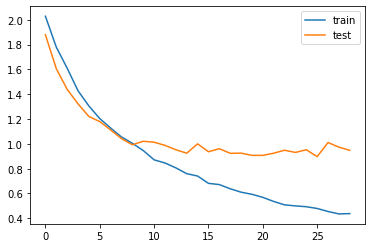

In [ ]:
#visualisasi hasil performance model
plt.plot(his_conv1d.his_conv1d['loss'], label='train')
plt.plot(his_conv1d.his_conv1d['val_loss'], label='test')
plt.legend()
plt.show()